# Neural Network Examples - Feature Learning

This notebook aims to **visually demonstrate the power of neural networks as heirarchical feature learners**. Beyond this conceptual goal, it also aims to be a lightweight introduction to building/training neural networks in **Keras**, a user-friendly python wrapper for **tensorflow**.

## Installing Keras
TRY THIS FIRST (in command line):

conda install -c conda-forge keras

If that doesn't work - 

conda install tensorflow  
move into a folder for installing tools  
git clone https://github.com/fchollet/keras.git  
cd keras  
python setup.py install  

In [1]:
#Installing network structure viz

#!pip install pydot-ng
#!brew install graphviz
#!pip install pydot

## Digit Images Example (MNist)

We'll start by simply loading in the MNist digits data (restricted to digits 0-4), doing some PCA visualization in 2 dimensions, and seeing how well a simple linear model (softmax regression) can perform on this 2-dim representation.

In [2]:
from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mnist = fetch_mldata("MNIST Original")
X_digits, Y_digits = mnist.data, mnist.target
X_digits, Y_digits = X_digits[Y_digits < 5], Y_digits[Y_digits < 5]

X_digits.shape

X_train, X_test, y_train, y_test = (train_test_split(X_digits, Y_digits, 
                                                     test_size = .2, random_state = 42))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


As usual, we want to standard scale before running PCA.

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Now we'll do dimensionality reduction to 2 principal components and visualize them. We can clearly see patterns that will let us separate the various digit classes, but also a lot of messiness. **We shouldn't expect a linear model to have outstanding performance** on this representation, since the classes are clearly not linearly separable.  

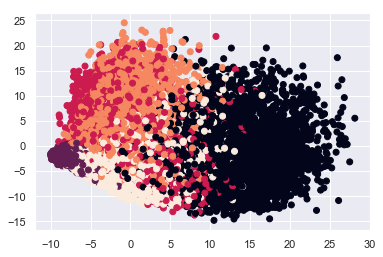

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

X_train_2PC = pca.fit_transform(X_train) 
X_test_2PC = pca.transform(X_test) 

plt.scatter(X_train_2PC[:,0], X_train_2PC[:,1], c = y_train)

Running the softmax regression confirms what we expected above - mediocre performance.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X_train_2PC, y_train)
lr.score(X_test_2PC, y_test)

0.6447460472925703

### Building a Neural Network Model

We've already taken the step of standard scaling our data, so we're nearly ready to build a NN. 

We do need to adjust the format of the training labels - right now we have a 1 dimensional array of digit labels like [0, 0, 1, 3, ...], but **multi-class NN output format requires a 2-dim array with binary columns corresponding to each class** (one hot encoding). Luckily, keras provides some utilities that let us easily reformat. 

In [6]:
from keras.utils import np_utils
y_train_cat = np_utils.to_categorical(y_train)

y_train_cat

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

Now we get to the fun part! We'll construct our first NN with Keras. 

Here's a quick breakdown of what all of these component parts are:

 * **Sequential** : default initialization of a multi-layer network
 * **Dense** : basic hidden layer type - fully connected, meaning that for each node we learn  a weight for each of the previous layer features, just like logistic regression. The first argument is the number of nodes (output feature dimensions) 
 
 
 * **Activation** : The nonlinearity we pass through at each layer. Typical choices are 'sigmoid', 'tanh', and 'relu', 'relu' often works best. The activation at the end (softmax in this case) corresponds to the output format we want, which in this case is multi-class. We would use sigmoid for binary classification, and no activation for a regression problem.
 * **Loss** and **Optimizer** : Which loss function to optimize for, and which style of gradient descent to use. 'adam' : adaptive momentum, often works really well for optimizing.
 
 
 * **Epochs** : Number of passes through the training data. Too few can underfit, too many can  overfit. Can be optimized with validation/CV including with early stopping methods.
 * **Batch Size** : Number of samples per gradient update. CF stochastic gradient descent - we train NNs through mini-batch gradient descent, and this controlls the mini-batch size. Larger batch sizes will lead to faster epochs but run the risk of causing arrival at local minima. 

In [7]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout

'''
 In this network structure, note that we follow a very common heuristic of "funneling"
 to lower dimensional representations over time with multiple layers. Tuning the exact
 choice of number of nodes and layers is quite challenging and there aren't generically
 correct choices, but this heuristic often works pretty well.
'''

NN = Sequential()

NN.add(Dense(100, input_dim = 784)) # need feature input dim (28x28) for first hidden layer
NN.add(Activation('relu'))

NN.add(Dense(20))
NN.add(Activation('relu'))

NN.add(Dense(2)) # note we would typically use higher dim than this for last hidden layer
NN.add(Activation('relu', name = '2D_layer')) # naming this layer so we can extract it later

NN.add(Dense(5))
NN.add(Activation('softmax'))

NN.compile(loss='categorical_crossentropy', optimizer='adam')
NN.fit(X_train, y_train_cat, epochs=20, batch_size=512, verbose=1) # track progress as we fit


Epoch 1/20
28588/28588 [==============================] - 1s 31us/step - loss: 1.2110
Epoch 2/20
28588/28588 [==============================] - 0s 12us/step - loss: 0.8384
Epoch 3/20
28588/28588 [==============================] - 0s 12us/step - loss: 0.6179
Epoch 4/20
28588/28588 [==============================] - 0s 11us/step - loss: 0.5285
Epoch 5/20
28588/28588 [==============================] - 0s 12us/step - loss: 0.4833
Epoch 6/20
28588/28588 [==============================] - 0s 10us/step - loss: 0.4441
Epoch 7/20
28588/28588 [==============================] - 0s 10us/step - loss: 0.3922
Epoch 8/20
28588/28588 [==============================] - 0s 11us/step - loss: 0.3080
Epoch 9/20
28588/28588 [==============================] - 0s 10us/step - loss: 0.2699
Epoch 10/20
28588/28588 [==============================] - 0s 10us/step - loss: 0.2485
Epoch 11/20
28588/28588 [==============================] - 0s 10us/step - loss: 0.2303
Epoch 12/20
28588/28588 [===========================

We've built and trained our model already, but even before training it we can get a summary of the network structure and visualize it to understand exactly how the model is set up.   

In [8]:
NN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
2D_layer (Activation)        (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 15        
__________

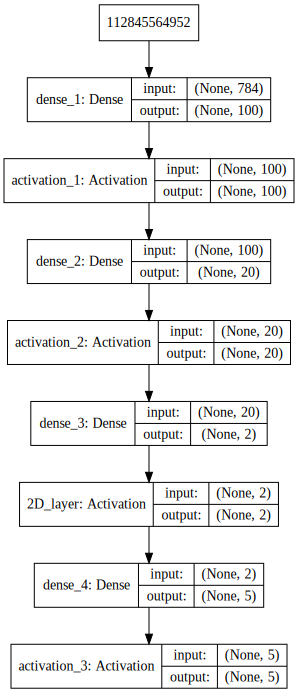

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(NN, show_shapes=True).create(prog='dot', format='svg'))

Of course we can also run predictions and score our model on the test data. It does really well!

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, NN.predict_classes(X_test))

0.9826500629634812

Next, to build some visual intuition for how neural networks perform **representation learning by creating new features (often in reduced dimensions)**, we're going to do something neat: extract the two node outputs from the last hidden layer and visualize them. 

In [11]:
feature_extractor = \
    Model(inputs=NN.input, outputs=NN.get_layer('2D_layer').output) 

X_train_NN_features_2d = feature_extractor.predict(X_train)
X_test_NN_features_2d = feature_extractor.predict(X_test)

Now we'll plot the 2 feature representation learned by the neural network, and compare with the 2 principle components of the original data as before. Look at how the **neural network has created a beautiful, linearly separable representation** of the original data. 

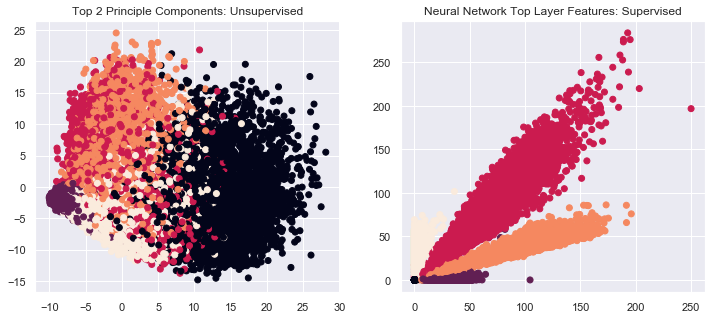

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].scatter(X_train_2PC[:,0], X_train_2PC[:,1], c = y_train)
axes[0].set_title('Top 2 Principle Components: Unsupervised')

axes[1].scatter(X_train_NN_features_2d[:,0], X_train_NN_features_2d[:,1], c = y_train)
axes[1].set_title('Neural Network Top Layer Features: Supervised')

And as expected, a softmax regression shows very strong performance on the data representation that the network has learned. 

In [13]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X_train_NN_features_2d, y_train)
lr.score(X_test_NN_features_2d, y_test)

0.9816706310340003

Hopefully this is a visually powerful representation of the **potential predictive power to be gained from using supervised feature learning / dimension reduction techniques**. Our neural network was designed to construct a 2-dimensional, linearly separable representation of the dataset and was able to accomplish this with flying colors.

Why does this happen? Here's some intuition. The network structure is set up to terminate in a simple softmax regression mapping to the final predictions (see output layer above). So the features that are fed to that mapping must be linearly separable for the network to predict well. In this sense, the **network is designed to create a final hidden layer of linearly separable features**. The beauty of the feed-forward / back-propogation structure is that it makes it possible to algorithmically generate this representation.

This is why I like to think of neural nets as **analagous to a supervised version of PCA**. They learn features in a heirarchical fashion that ultimately represent the input data in a much simpler and more useful way for prediction. 

PCA is unsupervised so can only represent the data in a simpler way based on explained variance, but neural nets are supervised so can represent the data in a simpler way based on **target explainability**.

## Digit Exercises

In [14]:
# EXERCISE: 
#   Reducing to a layer with 2 feature dimensions before the terminal softmax 
#   oversimplifies the model. Try adjusting the number of nodes in this layer to improve
#   the model's prediction performance.

# EXERCISE: 
#   Experiment with the network structure to try to improve performance. 
#   
#   Try adding or taking away nodes/layers. Look at the summary and visual diagram to
#   understand how the network and # of parameters are changing.

#   Try adjusting the number of epochs and the batch size. 
#   What impact do they have on performance?
#
#   Are you overfitting or underfitting? Is more or less complexity better? 
#   You can use # of parameters as a simple proxy for model complexity

# EXERCISE:
#   As you experiment with network structure, try to also incorporate dropout regularization.
#   See the bottom of the text example below for the syntax.

## Text Classification Example

Here we're going to look at a balanced binary text classification problem (sentiment detection), and train a **very simple neural network** - it will learn a 2-d representation of data just for the sake of visualization. Note that as in the digits example, this is making the model much simpler than it needs to be / below the level of complexity we would typically use in practice when building a predictive NN model.

In [15]:
import pandas as pd

df = pd.read_csv("Data/amazon_cells_labelled.txt", sep='\t', names=['text', 'sentiment'])
# Take a look
df.head()

,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, 
                                                    test_size=0.2, random_state = 42)

tfidf_vect = TfidfVectorizer(decode_error = 'ignore')
X_train = tfidf_vect.fit_transform(X_train).todense()
X_test = tfidf_vect.transform(X_test).todense()

X_train.shape

(800, 1630)

Here's our simple network to get a supervised, **2-dimensional embedding of the the tf-idf features**. 

In [17]:
NN = Sequential()

NN.add(Dense(2, input_dim = X_train.shape[1], name = '2D_layer'))
NN.add(Activation('relu'))

NN.add(Dense(1))
NN.add(Activation('sigmoid'))

NN.compile(loss='binary_crossentropy', optimizer='adam')
NN.fit(X_train, y_train, epochs=65, batch_size=128, verbose=1)

Epoch 1/65
800/800 [==============================] - 0s 293us/step - loss: 0.6930
Epoch 2/65
800/800 [==============================] - 0s 21us/step - loss: 0.6915
Epoch 3/65
800/800 [==============================] - 0s 18us/step - loss: 0.6899
Epoch 4/65
800/800 [==============================] - 0s 21us/step - loss: 0.6882
Epoch 5/65
800/800 [==============================] - 0s 22us/step - loss: 0.6861
Epoch 6/65
800/800 [==============================] - 0s 20us/step - loss: 0.6836
Epoch 7/65
800/800 [==============================] - 0s 28us/step - loss: 0.6810
Epoch 8/65
800/800 [==============================] - 0s 20us/step - loss: 0.6781
Epoch 9/65
800/800 [==============================] - 0s 20us/step - loss: 0.6751
Epoch 10/65
800/800 [==============================] - 0s 20us/step - loss: 0.6718
Epoch 11/65
800/800 [==============================] - 0s 19us/step - loss: 0.6684
Epoch 12/65
800/800 [==============================] - 0s 21us/step - loss: 0.6649
Epoch 13/65


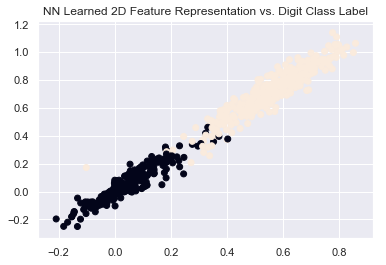

In [18]:
feature_extractor = \
    Model(inputs=NN.input, outputs=NN.get_layer('2D_layer').output) 

X_train_NN_features_2d = feature_extractor.predict(X_train)
X_test_NN_features_2d = feature_extractor.predict(X_test)

plt.scatter(X_train_NN_features_2d[:,0], X_train_NN_features_2d[:,1], c = y_train)
plt.title('NN Learned 2D Feature Representation vs. Digit Class Label')

Neural networks can be a very powerful tool for working with text data, **provided there is enough data**. In this case, we're only training on 800 samples so we should not expect amazing generalization results from the network.

As we can see from plotting the **learned features for the test data set**, the representation that works extremely well for the training data does not generalize as well to unseen data.

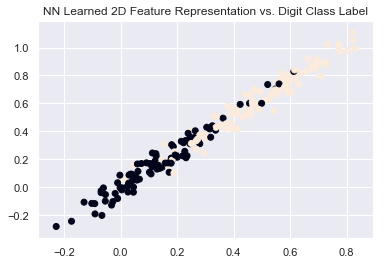

In [19]:
plt.scatter(X_test_NN_features_2d[:,0], X_test_NN_features_2d[:,1], c = y_test)
plt.title('NN Learned 2D Feature Representation vs. Digit Class Label')

In [20]:
accuracy_score(y_test, NN.predict_classes(X_test))

0.785

We can power up the complexity of this NN by adding more layers and choosing a higher number of dimensions (hidden nodes) for the top layer, but it's hard to really do much better than our simple network. This example demonstrates that there's a risk of learning a representation that's overfit to the training data. **This overfitting becomes increasingly likely if we make the network excessively complex (too many nodes + layers)**. 

In this case, **we're likely better off just using a simple model like logistic regression or naive bayes on tf-idf features due to the small data size**.

In [21]:
lr = LogisticRegression(C = 100)
lr.fit(X_train, y_train)
print('Simple logistic score: {}'.format(lr.score(X_test, y_test)))

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
print('Naive Bayes score: {}'.format(nb.score(X_test, y_test)))

Simple logistic score: 0.855
Naive Bayes score: 0.855


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


And here is the fancy 3 layer network, which doesn't seem to be a real improvement from a simple baseline at all. 

In [22]:
from sklearn.metrics import accuracy_score

NN = Sequential()

NN.add(Dense(200, input_dim = X_train.shape[1]))
NN.add(Activation('relu'))
NN.add(Dropout(.3))

NN.add(Dense(100))
NN.add(Activation('relu'))
NN.add(Dropout(.3))

NN.add(Dense(50)) # 50 dimensional top-layer representation
NN.add(Activation('relu'))
NN.add(Dropout(.3))

NN.add(Dense(1))
NN.add(Activation('sigmoid'))

NN.compile(loss='binary_crossentropy', optimizer='adam')
NN.fit(X_train, y_train, epochs=30, batch_size=512, verbose=1)

Epoch 1/30
800/800 [==============================] - 0s 525us/step - loss: 0.6940
Epoch 2/30
800/800 [==============================] - 0s 44us/step - loss: 0.6892
Epoch 3/30
800/800 [==============================] - 0s 43us/step - loss: 0.6867
Epoch 4/30
800/800 [==============================] - 0s 44us/step - loss: 0.6803
Epoch 5/30
800/800 [==============================] - 0s 47us/step - loss: 0.6761
Epoch 6/30
800/800 [==============================] - 0s 44us/step - loss: 0.6651
Epoch 7/30
800/800 [==============================] - 0s 47us/step - loss: 0.6537
Epoch 8/30
800/800 [==============================] - 0s 57us/step - loss: 0.6365
Epoch 9/30
800/800 [==============================] - 0s 55us/step - loss: 0.6145
Epoch 10/30
800/800 [==============================] - 0s 52us/step - loss: 0.5892
Epoch 11/30
800/800 [==============================] - 0s 46us/step - loss: 0.5561
Epoch 12/30
800/800 [==============================] - 0s 57us/step - loss: 0.5213
Epoch 13/30


In [23]:
accuracy_score(y_test, NN.predict_classes(X_test))

0.83

## Text Classification: Moving Beyond the Simple Fully-Connected Model

When it comes to handling unstructured data, the real power of neural networks starts to become clear when we move beyond the simple computational graph of fully-connected models. With neural nets, we're able to arbitrarily piece together building blocks of matrix algebra transformations to create models that mimic the underlying patterns present in the data we're modeling. Once we've constructed a graph that mimics these patterns, we can train for the optimal weights of the linear algebraic transformations with our old friend backpropagation/gradient descent. 

For example, we can treat a text as a sequence of words and process these words in an explicitly sequential manner. This style captures the **spatial patterns** of word usage, which are extremely relevant to how humans communicate; in previous methods we've seen like word-counting/tf-idf, our models were completely unaware of order, which may cause us to lose lots of predictive signal. We'll see another example later on (convolutional neural networks) in working with images. 

Below is an example of the computational graph structure of a **Recurrent Neural Network (RNN)**. For our simple sentiment classification exercise, we can ignore the multiple output steps and treat this network as a mechanism for storing a "memory" and sequentially updating it as new information comes in word by word, then using the final state of the "memory" to make a fixed prediction.

![rnn](img/rnn3.jpg)

We'll build a modern variant of this neural net architecture, the **Long Short-Term Memory (LSTM) network**. At its core is the computational engine shown above, with some added complexity around the memory updating strategy. In the process of building the LSTM we'll also see the typical preprocessing steps required for leveraging this network architecture for NLP problems.

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

seq_len = 100 # standardized length of each word sequence 
max_vocab = 1500 # max number of words to consider when tokenizing (based on freq)

# fit tokenizer vocab (note that it lowercases and strips punct)
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(df.text)

# standard train/val split
train_text, val_text, y_train, y_val = train_test_split(df.text, df.sentiment, 
                                                        test_size=0.2, random_state = 42)

# convert train and val texts to token sequences of standardized length 100,
# padding fills leading 0s in or cuts off sequence at 100th word
train_text = tokenizer.texts_to_sequences(train_text) 
train_text = pad_sequences(train_text, maxlen=seq_len)

val_text = tokenizer.texts_to_sequences(val_text)
val_text = pad_sequences(val_text, maxlen=seq_len)

train_text[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 108, 280, 120], dtype=int32)

Now we use the **keras functional API** to create a computational mapping from input text sequences to output sentiment binary targets. We'll actually make the LSTM component of the model **bidirectional**, meaning that we process the text both front-to-back and back-to-front, allowing us to capture a rich set of context. 

In [25]:
from keras.layers import Input, Embedding, Bidirectional, LSTM
from keras.models import Model

embedding_dim = 20 # hyper-parameter 

inp = Input(shape=(seq_len,)) # must specify format of input layer
x = Embedding(max_vocab, embedding_dim)(inp) # model learns its own word embeddings
x = Bidirectional(LSTM(8, recurrent_dropout=.3))(x) # bi-LSTM with regularization
y = Dense(1, activation='sigmoid')(x)

NN = Model(inp, y)
NN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 20)           30000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1856      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 31,873
Trainable params: 31,873
Non-trainable params: 0
_________________________________________________________________


The below diagram may start to confuse you more than it illuminates, but it helps emphasize the manner in which an RNN can be bidirectional:

![rnn](img/rnn.png)

Without further ado, we fit the model and track its train and validation accuracy over the training epochs. Then we'll plot the accuracy curves to get a feel for the accuracy trajectory. 

In [26]:
NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = NN.fit(train_text, y_train, 
                 validation_data=(val_text, y_val),
                 epochs=50, batch_size=512, verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 2s 3ms/step - loss: 0.6929 - acc: 0.5238 - val_loss: 0.6926 - val_acc: 0.5250
Epoch 2/50
800/800 [==============================] - 0s 561us/step - loss: 0.6919 - acc: 0.5963 - val_loss: 0.6926 - val_acc: 0.5750
Epoch 3/50
800/800 [==============================] - 0s 560us/step - loss: 0.6911 - acc: 0.6025 - val_loss: 0.6924 - val_acc: 0.5600
Epoch 4/50
800/800 [==============================] - 0s 588us/step - loss: 0.6902 - acc: 0.6037 - val_loss: 0.6920 - val_acc: 0.5550
Epoch 5/50
800/800 [==============================] - 0s 548us/step - loss: 0.6894 - acc: 0.6125 - val_loss: 0.6917 - val_acc: 0.5450
Epoch 6/50
800/800 [==============================] - 1s 665us/step - loss: 0.6883 - acc: 0.6237 - val_loss: 0.6912 - val_acc: 0.5650
Epoch 7/50
800/800 [==============================] - 0s 504us/step - loss: 0.6872 - acc: 0.6138 - val_loss: 0.6907 - val_acc: 0.5550
Epoch 8/50
800/800

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


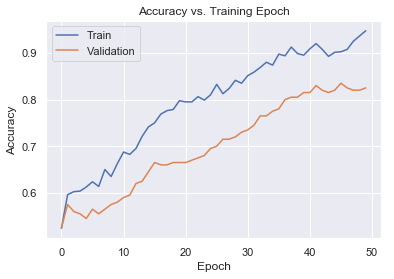

In [27]:
%pylab inline 

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Accuracy vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

Hmm it looks like we really can't do any better than our amazing naive bayes/logistic baseline!

In [28]:
accuracy_score(y_val, (NN.predict(val_text)[:,0] > .5).astype(int))

0.825

## Text Classification: Leveraging The Power Of Transfer Learning

Well no, actually we can do better than that baseline. But we'll have to do more, effectively leveraging a much larger text dataset than our paltry 1000 records: we'll use **transfer learning**. Transfer learning broadly refers to the process of training neural network weights on one dataset/task, then taking those weights and applying them to a different dataset/task. It sounds like it shouldn't really work, but it turns out that since neural net weights can learn very rich representations of fairly low-level, generalizable concepts, these weights often have broad applicability. Since these weights can be learned on massive datasets and ported over to much smaller ones, this method often helps us essentially use a lot more data than we immediately have on hand for training.

One classic example of transfer learning, which we'll see here, is use of **pre-trained word vectors**. Recall that word vectors are learned via the task of predicting what words appear in similar contexts. This training task allows the vectors to capture a great deal of semantic and syntactic information that often gives relevant signal for other prediction tasks. We'll test this out by **using google's pre-trained word vectors as fixed word embeddings in our sentiment model**, instead of training embeddings on the fly. 

The code below is adapted from: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html. First we load the word vectors and build an embedding matrix.

In [29]:
import numpy as np
from gensim.models.keyedvectors import KeyedVectors

word_index = tokenizer.word_index

# change the path to point to your pretrained google vectors file
w2v_file = '/Users/jeddy-metis/nltk_data/GoogleNews-vectors-negative300.bin.gz'

# load the w2v vectors using gensim
word_vectors = KeyedVectors.load_word2vec_format(w2v_file, binary=True)

embedding_dim = 300 # w2v embedding dim

# use the gensim model to build a numpy array of embeddings,
# we'll feed this array to the keras embeddings layer.
# each row i of the array will correspond to the word token assigned to that value 
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except: # word in our data vocab is missing in w2v, will use 0 vector for that word
        pass

Now we have what we need to define the model.

In [30]:
from keras.layers import Input, Embedding, Bidirectional, LSTM
from keras.models import Model

inp = Input(shape=(seq_len,))
x = Embedding(len(word_index) + 1,
              embedding_dim,
              weights=[embedding_matrix], # where we feed the pretrained vecs
              trainable=False)(inp) # freeze these parameters in the model

x = Bidirectional(LSTM(64, recurrent_dropout=.1))(x)
x = Dense(32)(x) # fully connected layer on top of the output of the bi-LSTM
x = Dropout(16)(x)
y = Dense(1, activation='sigmoid')(x)

NN = Model(inp, y)
NN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          563700    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 754,741
Trainable params: 191,041
Non-trainable params: 563,700
________________________________________________________________

Let's train and see how we did!

In [31]:
NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = NN.fit(train_text, y_train, 
                 validation_data=(val_text, y_val),
                 epochs=30, batch_size=512, verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 6s 8ms/step - loss: 0.6919 - acc: 0.5263 - val_loss: 0.6857 - val_acc: 0.6150
Epoch 2/30
800/800 [==============================] - 3s 3ms/step - loss: 0.6814 - acc: 0.6475 - val_loss: 0.6796 - val_acc: 0.6150
Epoch 3/30
800/800 [==============================] - 3s 4ms/step - loss: 0.6709 - acc: 0.6825 - val_loss: 0.6703 - val_acc: 0.6600
Epoch 4/30
800/800 [==============================] - 3s 4ms/step - loss: 0.6587 - acc: 0.7013 - val_loss: 0.6576 - val_acc: 0.6750
Epoch 5/30
800/800 [==============================] - 3s 4ms/step - loss: 0.6441 - acc: 0.7313 - val_loss: 0.6406 - val_acc: 0.6950
Epoch 6/30
800/800 [==============================] - 2s 3ms/step - loss: 0.6249 - acc: 0.7550 - val_loss: 0.6202 - val_acc: 0.6950
Epoch 7/30
800/800 [==============================] - 3s 4ms/step - loss: 0.6027 - acc: 0.7575 - val_loss: 0.5968 - val_acc: 0.7150
Epoch 8/30
800/800 [==========

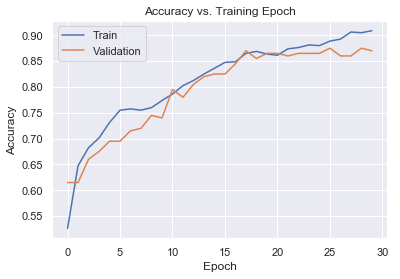

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Accuracy vs. Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

Looks like we can improve over the naive bayes baseline by at least 2% or so using the google vectors. So there's hope for deep learning after all! (once again, a big problem with this dataset is that 1000 records is just a very small size for neural net methods. It already should strike you as extremely promising that we can do so well with the transfer learning method here).